In [1]:
import pandas as pd
import random
import numpy as np
from tqdm.notebook import tqdm
import os
from matplotlib import pyplot as plt
import seaborn as sns
import time

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, accuracy_score

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080


In [4]:
MAX_LEN = 100
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 2e-5

# Helper Function

In [5]:
def seed_data(seed_val=42):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Data preparation

In [6]:
class SentimentDataSet(Dataset):
    def __init__(self, tokenizer, data_text, labels, max_len):
        self.tokenizer = tokenizer
        self.data_text = data_text
        self.labels = labels
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data_text)
    
    def __getitem__(self, index):
        text_data = self.data_text[index]
        inputs = self.tokenizer.encode_plus(
            text_data,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'targets': torch.tensor(self.labels[index], dtype=torch.long)
        }

In [7]:
df = pd.read_csv('data/filtered.csv')
df = df.dropna()
df['target'] = df['target'].apply(lambda x:1 if x == 4 else 0)

# Split train, test, split
train_df, test_df = train_test_split(
    df, random_state=2020, test_size=0.2
)

test_df, valiation_df = train_test_split(
    test_df, random_state=2020, test_size=0.5
)

train_sentences = train_df['text'].tolist()
train_labels = train_df['target'].tolist()

test_sentences = test_df['text'].tolist()
test_labels = test_df['target'].tolist()

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [10]:
# Load data into data loader
train_dataset = SentimentDataSet(tokenizer, train_sentences, train_labels, MAX_LEN)
test_dataset = SentimentDataSet(tokenizer, test_sentences, test_labels, MAX_LEN)

In [11]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_sampler = SequentialSampler(test_dataset)
validation_dataloader = DataLoader(test_dataset, sampler=validation_sampler, batch_size=BATCH_SIZE)

# Bert model

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

# Training

In [13]:
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=1e-8
)

In [14]:
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [15]:
seed_data(10)

loss_values = []
train_acc = []

for epoch_i in tqdm(range(EPOCHS)):
    print('Training...')
    
    t0 = time.time()
    total_loss = 0
    pred_labels = []
    
    model.train()
    
    for index, batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        input_ids = batch['ids'].to(device)
        attn_mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['targets'].to(device)
        
        model.zero_grad()
        outputs = model(
            input_ids, 
            token_type_ids=token_type_ids, 
            attention_mask=attn_mask, 
            labels=labels
        )
        
        loss, logits = outputs[:2]
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        scheduler.step()
        preds = F.softmax(logits).detach().cpu().numpy()
        pred_labels.append(np.argmax(preds))

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    
    print("")
    print("Running Validation")
    
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_samples = 0, 0
    
    for index, batch in tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
        input_ids = batch['ids'].to(device)
        attn_mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['targets'].to(device)
        
        with torch.no_grad():
            outputs = model(
                input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attn_mask
            )
            
        logits = outputs[0]
        
        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, 1).flatten()
        labels_flat = labels.flatten()
        tmp_eval_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
        
        eval_accuracy += tmp_eval_acc
        
        nb_eval_steps += 1
    
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

Training...


/home/superceed1/anaconda3/envs/py36torch14/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.




  Average training loss: 0.327

Running Validation



  Accuracy: 0.87
Training...




  Average training loss: 0.262

Running Validation



  Accuracy: 0.88



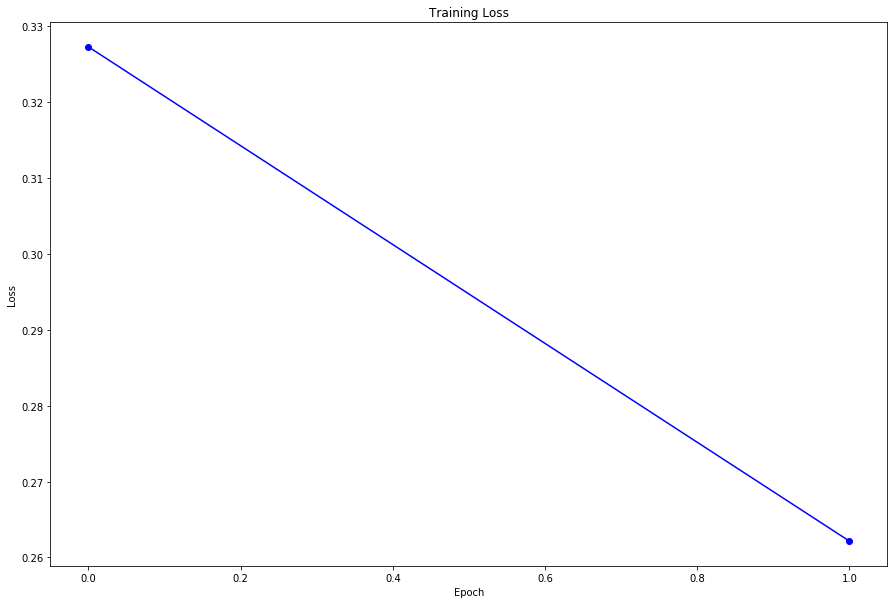

In [16]:
plt.figure(figsize=(15, 10))
plt.title('Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values, 'b-o')

# Evaluate model

In [17]:
y_true = test_df['target'].tolist()

In [18]:
x_true = test_df['text'].tolist()

In [19]:
model.eval()
y_pred = []

for x_val in x_true:
    tokenized = tokenizer.encode_plus(
        x_val,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True
    )
    
    input_ids = torch.tensor(tokenized['input_ids'], dtype=torch.long).unsqueeze_(0).to(device)
    token_type_ids = torch.tensor(tokenized['token_type_ids'], dtype=torch.long).unsqueeze_(0).to(device)
    attn_mask = torch.tensor(tokenized['attention_mask'], dtype=torch.long).unsqueeze_(0).to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attn_mask
        )
        pred = F.softmax(outputs[0]).detach().cpu().numpy()
        y_pred.append(np.argmax(pred))

/home/superceed1/anaconda3/envs/py36torch14/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

           0       0.87      0.88      0.88     79995
           1       0.88      0.87      0.87     79725

    accuracy                           0.88    159720
   macro avg       0.88      0.88      0.88    159720
weighted avg       0.88      0.88      0.88    159720

MCC: 0.750


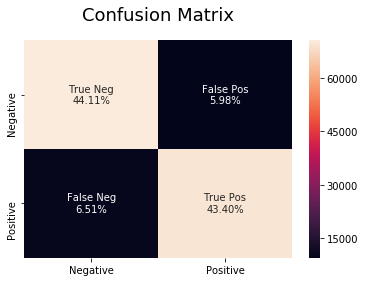

In [20]:
print(classification_report(y_true, y_pred))

mcc = matthews_corrcoef(y_true, y_pred)
print('MCC: %.3f' % mcc)

cm = confusion_matrix(y_true, y_pred)

categories = ['Negative', 'Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']

group_percentage = [
    '{0:.2%}'.format(value) for value in cm.ravel() / cm.sum()
]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentage)]

labels = np.array(labels).reshape(2, 2)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
sns.heatmap(
    cm, annot=labels, fmt='',
    xticklabels=categories, yticklabels=categories
)

# Save model

In [21]:
if not os.path.exists('weights/'):
    os.makedirs('weights/')
    
torch.save(model, 'weights/bert_sentiment_analysis.pth')

In [22]:
y_pred

[1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
